In [124]:
from IPython.display import display
from collections import defaultdict
from matplotlib.ticker import FuncFormatter
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import os
import os
import pandas as pd
import random
import re
import scipy.stats as stats
import seaborn as sns

data_dir = "C:/Users/zabit/Documents/GitHub/Statistikos-lab-2/data"

folders = [folder for folder in os.listdir(data_dir) 
           if os.path.isdir(os.path.join(data_dir, folder))]

print("Nekilnojamojo turto duomenų kategorijos:")
for folder in folders:
    print(folder)


Nekilnojamojo turto duomenų kategorijos:
apartments
apartments_rent
garages_parking
garages_parking_rent
houses
house_rent
land
land_rent
premises
premises_rent


In [125]:
csv_data_dict = {}

for folder in folders:
    file_path = os.path.join(data_dir, folder, "all_cities_20240214.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        csv_data_dict[folder] = df

min_threshold = 20
max_threshold = 25000000

# Ieškome išskirčių
for data_type in csv_data_dict:
    if "price" in csv_data_dict[data_type].columns:
        extreme_high = (csv_data_dict[data_type]["price"] > max_threshold).sum()
        extreme_low = (csv_data_dict[data_type]["price"] < min_threshold).sum()
        extreme_total = extreme_high + extreme_low
        
        if extreme_total > 0:
            # Filtruojame duomenis
            csv_data_dict[data_type] = csv_data_dict[data_type][
                ((csv_data_dict[data_type]["price"] >= min_threshold) & 
                 (csv_data_dict[data_type]["price"] <= max_threshold))
            ]

data_sizes = pd.DataFrame({
    "Eilučių_skaičius": [df.shape[0] for df in csv_data_dict.values()],
    "Stulpelių_skaičius": [df.shape[1] for df in csv_data_dict.values()]
}, index=csv_data_dict.keys())

display(data_sizes)

,Eilučių_skaičius,Stulpelių_skaičius
apartments,7721,38
apartments_rent,3208,38
garages_parking,497,28
garages_parking_rent,307,27
houses,7284,39
house_rent,310,40
land,6322,27
land_rent,102,27
premises,1491,37
premises_rent,2547,37


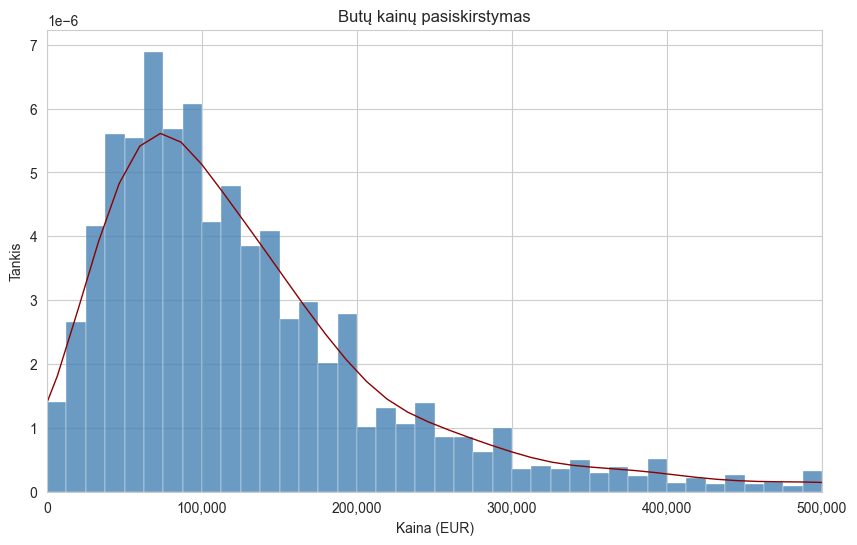

In [126]:
prices = csv_data_dict["apartments"]["price"].dropna()

fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=prices, 
    bins=200, 
    color="steelblue", 
    alpha=0.8, 
    stat="density", 
    edgecolor="white",
    ax=ax
)

sns.kdeplot(
    data=prices,
    color="darkred", 
    linewidth=1,
    ax=ax
)

def comma_formatter(x, pos):
    return f"{x:,.0f}"

ax.xaxis.set_major_formatter(FuncFormatter(comma_formatter))

ax.set_title("Butų kainų pasiskirstymas")
ax.set_xlabel("Kaina (EUR)")
ax.set_ylabel("Tankis")
ax.set_xlim(0, 500000) 

plt.show()

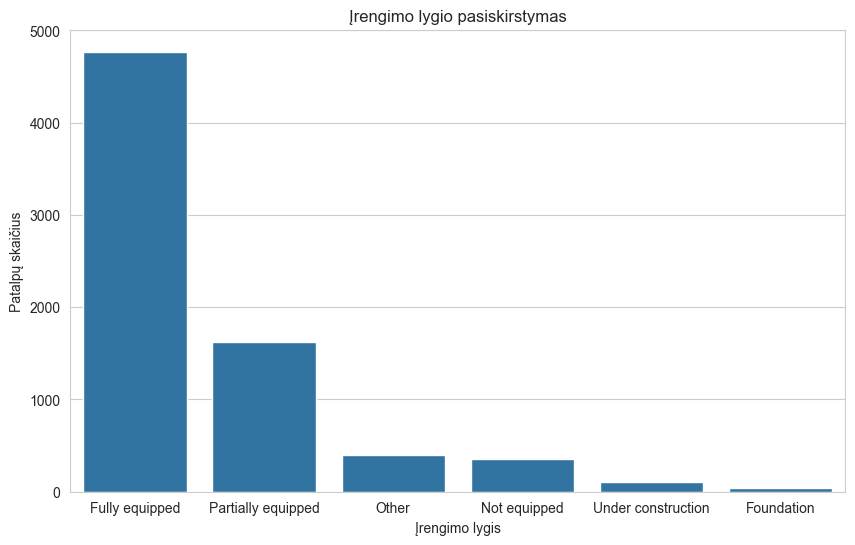

In [127]:
duom = pd.read_excel("duomenys.xlsx")

equipment_counts = duom['equipment'].value_counts().reset_index()
equipment_counts.columns = ['equipment', 'count']

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='equipment', y='count', data=equipment_counts)

plt.title("Įrengimo lygio pasiskirstymas")
plt.xlabel("Įrengimo lygis")
plt.ylabel("Patalpų skaičius")

plt.show()

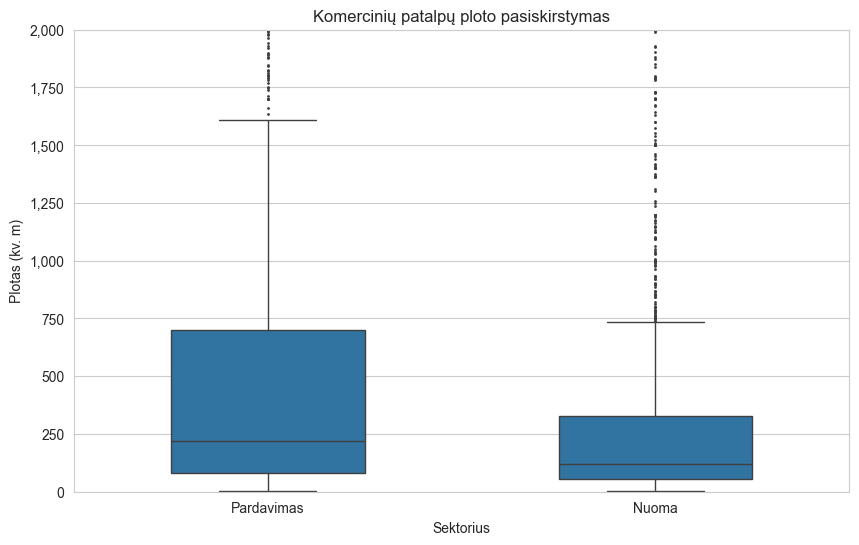

In [128]:
premises_types = ["premises", "premises_rent"]
premises_data = {}

# Sujungiame duomenis
for type_name in premises_types:
    if type_name in csv_data_dict and "area" in csv_data_dict[type_name].columns:
        df = csv_data_dict[type_name].copy()
        
        df['type'] = "Pardavimas" if type_name == "premises" else "Nuoma"
        if df['area'].dtype == object:
            df['area'] = pd.to_numeric(df['area'].astype(str).str.replace(',', '.'), errors='coerce')

        df = df[~df['area'].isna() & (df['area'] > 0) & (df['area'] < 10000)]
        
        if premises_data:
            common_cols = list(set(df.columns).intersection(set(premises_data[list(premises_data.keys())[0]].columns)))
            df = df[common_cols]
        
        premises_data[type_name] = df

if len(premises_data) == 2:
    common_cols = list(set(premises_data[premises_types[0]].columns).intersection(
                       set(premises_data[premises_types[1]].columns)))
    
    # Išsaugojame tik bendrus stulpelius
    for type_name in premises_types:
        premises_data[type_name] = premises_data[type_name][common_cols]

combined_premises = pd.concat(premises_data.values(), ignore_index=True)

plt.figure(figsize=(10, 6))

ax = sns.boxplot(x="type", y="area", data=combined_premises, 
                width=0.5,
                fliersize=1)

ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))

plt.title("Komercinių patalpų ploto pasiskirstymas")
plt.xlabel("Sektorius")
plt.ylabel("Plotas (kv. m)")

plt.ylim(0, 2000)

plt.show()

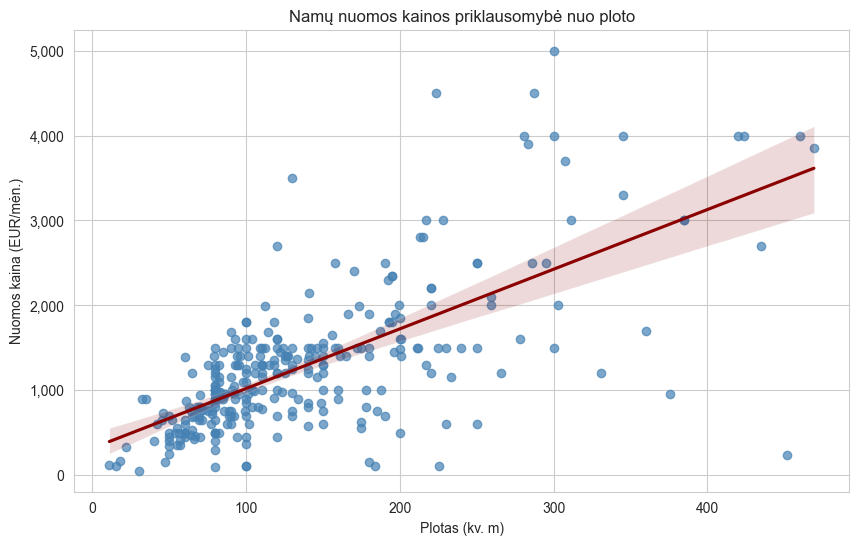

Koreliacijos koeficientas tarp namų ploto ir nuomos kainos: 0.692


In [129]:
df = csv_data_dict["house_rent"].copy()

# Sutvarkome ploto duomenis
if df['area'].dtype == object:
    df['area'] = pd.to_numeric(df['area'].astype(str).str.replace(',', '.'), errors='coerce')

df = df[~df['area'].isna() & ~df['price'].isna() &
        (df['area'] > 0) & (df['area'] < 500) &
        (df['price'] > 0) & (df['price'] < 6000)]

df['price_per_sqm'] = df['price'] / df['area']

plt.figure(figsize=(10, 6))

ax = sns.regplot(
    x='area', 
    y='price', 
    data=df,
    scatter_kws={'alpha': 0.7, 'color': 'steelblue'},
    line_kws={'color': 'darkred'}
)

ax.xaxis.set_major_formatter(FuncFormatter(comma_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))

plt.title("Namų nuomos kainos priklausomybė nuo ploto")
plt.xlabel("Plotas (kv. m)")
plt.ylabel("Nuomos kaina (EUR/mėn.)")

correlation = df['area'].corr(df['price'])

plt.show()

print(f"Koreliacijos koeficientas tarp namų ploto ir nuomos kainos: {correlation:.3f}")

In [ ]:
def filter_datasets_by_column(data_dict, column_name):
    filtered = {k: v for k, v in data_dict.items() if column_name in v.columns}
    return filtered

def calculate_summary(data_dict, variable_name, target_datasets):
    results = pd.DataFrame(columns=[
        'Duomenų_rinkinys', 'Vidurkis', 'Mediana', 'Stand_nuokr',
        'Q1', 'Q3', 'Minimumas', 'Maksimumas'
    ])
    
    for df_name in target_datasets:
        if df_name in data_dict and variable_name in data_dict[df_name].columns:
            values = data_dict[df_name][variable_name]
            
            if values.dtype == object:
                numeric_values = pd.to_numeric(values.astype(str).str.replace(',', '.'), errors='coerce')
            else:
                numeric_values = values
            
            clean_values = numeric_values.dropna()
            
            if len(clean_values) > 0:
                mean_val = clean_values.mean()
                median_val = clean_values.median()
                sd_val = clean_values.std()
                quant_vals = clean_values.quantile([0.25, 0.75])
                min_val = clean_values.min()
                max_val = clean_values.max()
                
                new_row = pd.DataFrame({
                    'Duomenų_rinkinys': [df_name],
                    'Vidurkis': [mean_val],
                    'Mediana': [median_val],
                    'Stand_nuokr': [sd_val],
                    'Q1': [quant_vals[0.25]],
                    'Q3': [quant_vals[0.75]],
                    'Minimumas': [min_val],
                    'Maksimumas': [max_val]
                })
                
                results = pd.concat([results, new_row], ignore_index=True)
    
    return results

columns_to_check = [
    "price", "price_per_month", "views_total", "area", "area_.a.", 
    "build_year", "no._of_floors", "floor", "number_of_rooms", "plot_area"
]

column_results = {}

for col in columns_to_check:
    column_results[col] = filter_datasets_by_column(csv_data_dict, col)

sale_datasets = ["apartments", "houses", "premises"]
rent_datasets = ["apartments_rent", "house_rent", "premises_rent"]
all_datasets = ["apartments", "apartments_rent", "house_rent", "houses", "premises", "premises_rent"]

sale_price_stats = calculate_summary(csv_data_dict, "price", sale_datasets)
rent_price_stats = calculate_summary(csv_data_dict, "price", rent_datasets)
views_stats = calculate_summary(csv_data_dict, "views_total", all_datasets)
floors_stats = calculate_summary(csv_data_dict, "no._of_floors", all_datasets)
rooms_stats = calculate_summary(csv_data_dict, "number_of_rooms", all_datasets)

def display_table(df, caption, decimals=2):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].round(decimals)
    
    print(f"\n{caption}")
    return df

display(display_table(sale_price_stats, "Pardavimų kainų statistika pagal nekilnojamojo turto tipą", 2))
display(display_table(rent_price_stats, "Nuomos kainų statistika pagal nekilnojamojo turto tipą", 2))
display(display_table(views_stats, "Peržiūrų skaičiaus statistika pagal nekilnojamojo turto tipą", 0))
display(display_table(floors_stats, "Aukštų skaičiaus statistika pagal nekilnojamojo turto tipą", 1))
display(display_table(rooms_stats, "Kambarių skaičiaus statistika pagal nekilnojamojo turto tipą", 1))


Pardavimų kainų statistika pagal nekilnojamojo turto tipą


C:\Users\zabit\AppData\Local\Temp\ipykernel_17496\1499549408.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)
C:\Users\zabit\AppData\Local\Temp\ipykernel_17496\1499549408.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)
C:\Users\zabit\AppData\Local\Temp\ipykernel_17496\1499549408.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is

,Duomenų_rinkinys,Vidurkis,Mediana,Stand_nuokr,Q1,Q3,Minimumas,Maksimumas
0,apartments,143718.13,107558.0,146129.71,64000.0,172000.0,43,2500000
1,houses,183734.43,140000.0,223884.94,55000.0,235000.0,200,4200000
2,premises,413170.38,165000.0,762212.43,70000.0,399850.0,490,10000000



Nuomos kainų statistika pagal nekilnojamojo turto tipą


,Duomenų_rinkinys,Vidurkis,Mediana,Stand_nuokr,Q1,Q3,Minimumas,Maksimumas
0,apartments_rent,609.95,525.0,1529.12,380.0,690.0,20,84900
1,house_rent,1428.76,1200.0,1327.40,750.0,1500.0,50,13000
2,premises_rent,886472.97,1300.0,3213628.37,500.0,5268.5,22,24045000



Peržiūrų skaičiaus statistika pagal nekilnojamojo turto tipą


,Duomenų_rinkinys,Vidurkis,Mediana,Stand_nuokr,Q1,Q3,Minimumas,Maksimumas
0,apartments,1573.0,892.0,2244.0,425.0,1860.0,0,56297
1,apartments_rent,1806.0,606.0,9703.0,286.0,1315.0,2,355786
2,house_rent,1275.0,582.0,2332.0,262.0,1411.0,20,24014
3,houses,2247.0,1133.0,3549.0,501.0,2612.0,2,71418
4,premises,647.0,310.0,1296.0,132.0,710.0,0,21298
5,premises_rent,742.0,257.0,2341.0,106.0,607.0,1,46715



Aukštų skaičiaus statistika pagal nekilnojamojo turto tipą


,Duomenų_rinkinys,Vidurkis,Mediana,Stand_nuokr,Q1,Q3,Minimumas,Maksimumas
0,apartments,5.1,5.0,3.0,3.0,5.0,1,34
1,apartments_rent,5.3,5.0,3.0,4.0,6.0,1,34
2,house_rent,1.8,2.0,0.6,1.0,2.0,1,4
3,houses,1.6,2.0,0.6,1.0,2.0,1.0,15.0
4,premises,2.4,2.0,1.9,1.0,3.0,1.0,18.0
5,premises_rent,2.8,2.0,2.9,1.0,3.0,1.0,31.0



Kambarių skaičiaus statistika pagal nekilnojamojo turto tipą


,Duomenų_rinkinys,Vidurkis,Mediana,Stand_nuokr,Q1,Q3,Minimumas,Maksimumas
0,apartments,2.4,2.0,1.0,2.0,3.0,1,13
1,apartments_rent,2.0,2.0,0.8,1.0,2.0,1,10
2,house_rent,4.2,4.0,1.7,3.0,5.0,1.0,13.0
3,houses,4.2,4.0,2.0,3.0,5.0,1.0,54.0


In [131]:
categorical_variables = ["sold_or_rented", "region", "equipment", 
                         "building_type", "private_seller"]

for variable in categorical_variables:
    freq = duom[variable].value_counts()
    
    table = pd.DataFrame({
        'Kintamasis': [variable] * len(freq),
        'Kategorija': freq.index,
        'Dažnis': freq.values
    })
    
    display(table)

,Kintamasis,Kategorija,Dažnis
0,sold_or_rented,False,7272
1,sold_or_rented,True,12


,Kintamasis,Kategorija,Dažnis
0,region,Vilnius,906
1,region,Vilniaus r. sav.,791
2,region,Klaipėdos r. sav.,651
3,region,Kauno r. sav.,591
4,region,Kaunas,419
...,...,...,...
105,region,Kalvarijos m.,2
106,region,Šiaulių m. sav.,2
107,region,Pagėgių m.,2
108,region,Lazdijų k.,1


,Kintamasis,Kategorija,Dažnis
0,equipment,Fully equipped,4768
1,equipment,Partially equipped,1619
2,equipment,Other,394
3,equipment,Not equipped,356
4,equipment,Under construction,110
5,equipment,Foundation,37


,Kintamasis,Kategorija,Dažnis
0,building_type,House,4353
1,building_type,Blocked house,1246
2,building_type,Farmstead,712
3,building_type,Garden house,510
4,building_type,Part of the house,350
5,building_type,Other,113


,Kintamasis,Kategorija,Dažnis
0,private_seller,False,5199
1,private_seller,True,2085


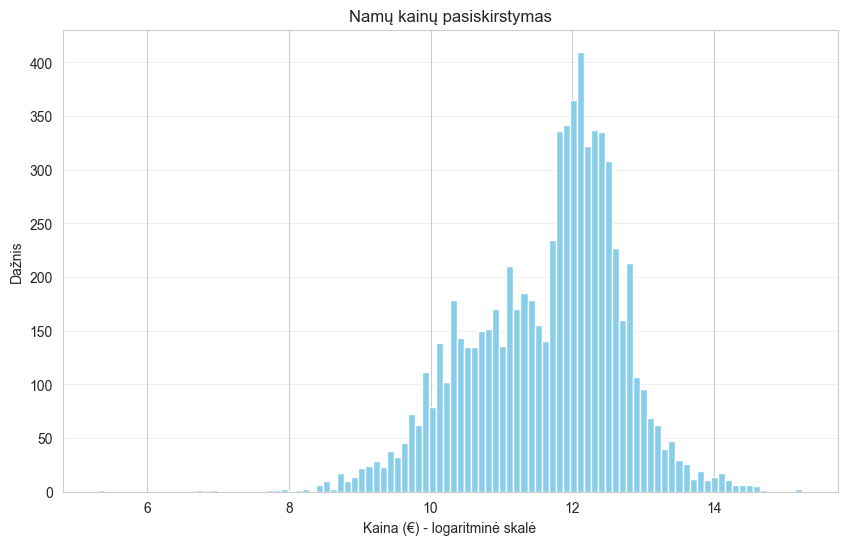

In [132]:
# log transformacija
duom['log_price'] = np.log(duom['price'])

plt.figure(figsize=(10, 6))
plt.hist(duom['log_price'], bins=100, color='skyblue', edgecolor='white')

plt.title("Namų kainų pasiskirstymas")
plt.xlabel("Kaina (€) - logaritminė skalė")
plt.ylabel("Dažnis")

plt.grid(axis='y', alpha=0.3)

plt.show()

In [133]:
log_mu = np.log(100000)

t_stat, p_value = stats.ttest_1samp(duom['log_price'].dropna(), log_mu)

print(f"t-testas:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.8f}")
print(f"Laisvės laipsniai: {len(duom['log_price'].dropna()) - 1}")

t-testas:
t-statistic: 9.2984
p-value: 0.00000000
Laisvės laipsniai: 7283


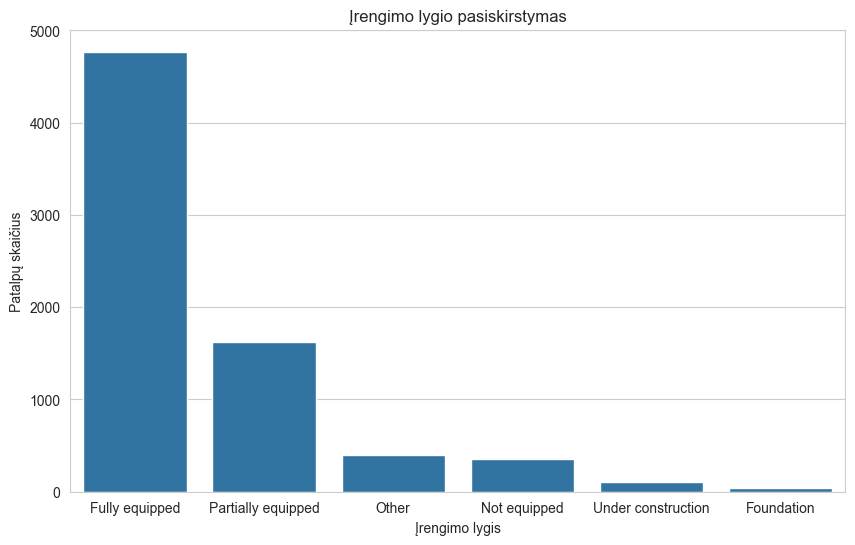

In [134]:
equipment_counts = duom['equipment'].value_counts().reset_index()
equipment_counts.columns = ['equipment', 'count']

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='equipment', y='count', data=equipment_counts)

plt.title("Įrengimo lygio pasiskirstymas")
plt.xlabel("Įrengimo lygis")
plt.ylabel("Patalpų skaičius")

plt.show()

equipped_count = duom[duom['equipment'].isin(['Fully equipped', 'Partially equipped'])].shape[0]

total_count = duom.shape[0]


In [ ]:
expected_proportion = 0.6

observed_proportion = equipped_count / total_count

x_corrected = abs(equipped_count - expected_proportion * total_count) - 0.5
if x_corrected < 0:
    x_corrected = 0
test_statistic = (x_corrected ** 2) / (expected_proportion * (1 - expected_proportion) * total_count)

p_value = 1 - stats.chi2.cdf(test_statistic, 1)

z = stats.norm.ppf(0.975)
denominator = 1 + z**2/total_count
p_adj = (equipped_count + z**2/2)/denominator
ci_half_width = z * np.sqrt((observed_proportion * (1 - observed_proportion) + z**2/(4*total_count))/total_count)/denominator
ci_lower = max(0, p_adj - ci_half_width)
ci_upper = min(1, p_adj + ci_half_width)

print("Proporcijos lygybė skaičiu")
print(f"duomenys: {equipped_count} iš {total_count}")
print(f"X-squared = {test_statistic:.4f}, df = 1, p-value = {p_value:.8f}")

Proporcijos lygybė skaičiu

duomenys: 6387 iš 7284
X-squared = 2325.1071, df = 1, p-value = 0.00000000


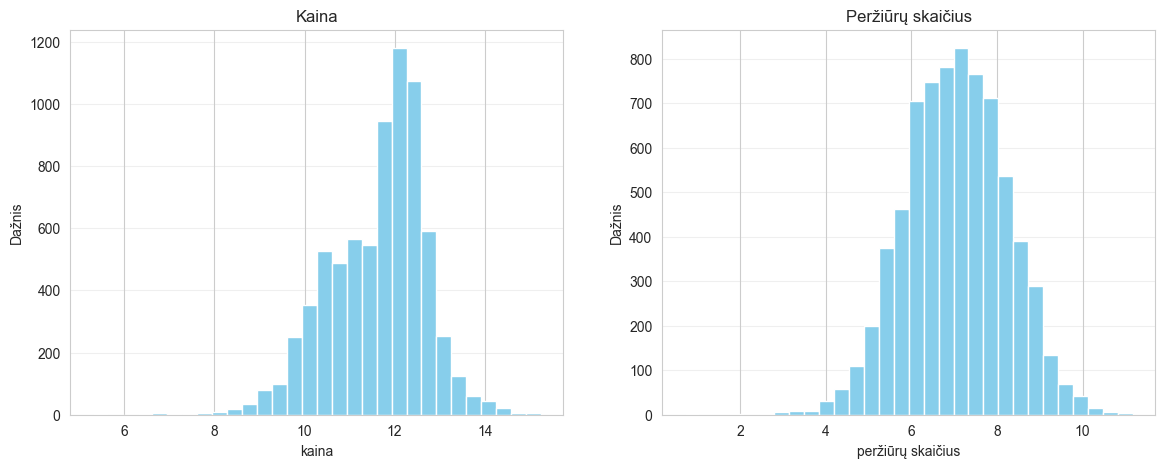

In [136]:
# log transformacija
duom['log_price'] = np.log(duom['price'])
duom['log_views_total'] = np.log(duom['views_total'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(duom['log_price'].dropna(), bins=30, color='skyblue', edgecolor='white')
ax1.set_title("Kaina")
ax1.set_xlabel("kaina")
ax1.set_ylabel("Dažnis")
ax1.grid(axis='y', alpha=0.3)

ax2.hist(duom['log_views_total'].dropna(), bins=30, color='skyblue', edgecolor='white')
ax2.set_title("Peržiūrų skaičius")
ax2.set_xlabel("peržiūrų skaičius")
ax2.set_ylabel("Dažnis")
ax2.grid(axis='y', alpha=0.3)

plt.show()

In [137]:
valid_data = duom.dropna(subset=['log_price', 'log_views_total'])

# Pirsono koreliacija
correlation, p_value = stats.pearsonr(valid_data['log_price'], valid_data['log_views_total'])

n = len(valid_data)
df = n - 2

r_z = np.arctanh(correlation)
se = 1/np.sqrt(n-3)
z = stats.norm.ppf(0.975)
ci_low = np.tanh(r_z - z*se)
ci_high = np.tanh(r_z + z*se)

print("Koreliacijos lygybė nuliu")
print()
print(f"duomenys: log_price ir log_views_total")
print(f"t = {correlation*np.sqrt(df/(1-correlation**2)):.4f}, df = {df}, p-value = {p_value:.8f}")

Koreliacijos lygybė nuliu

duomenys: log_price ir log_views_total
t = -11.5535, df = 7282, p-value = 0.00000000


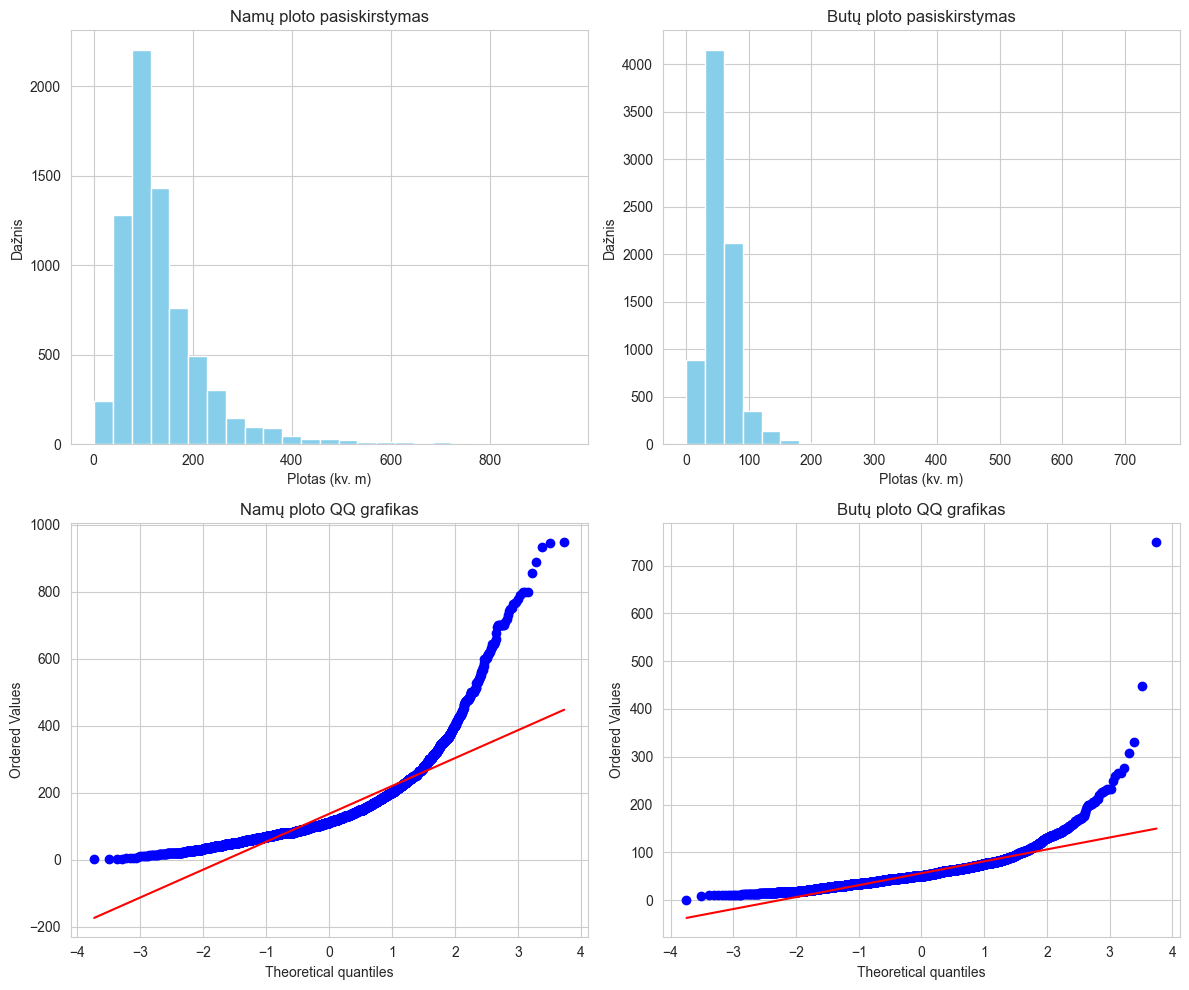

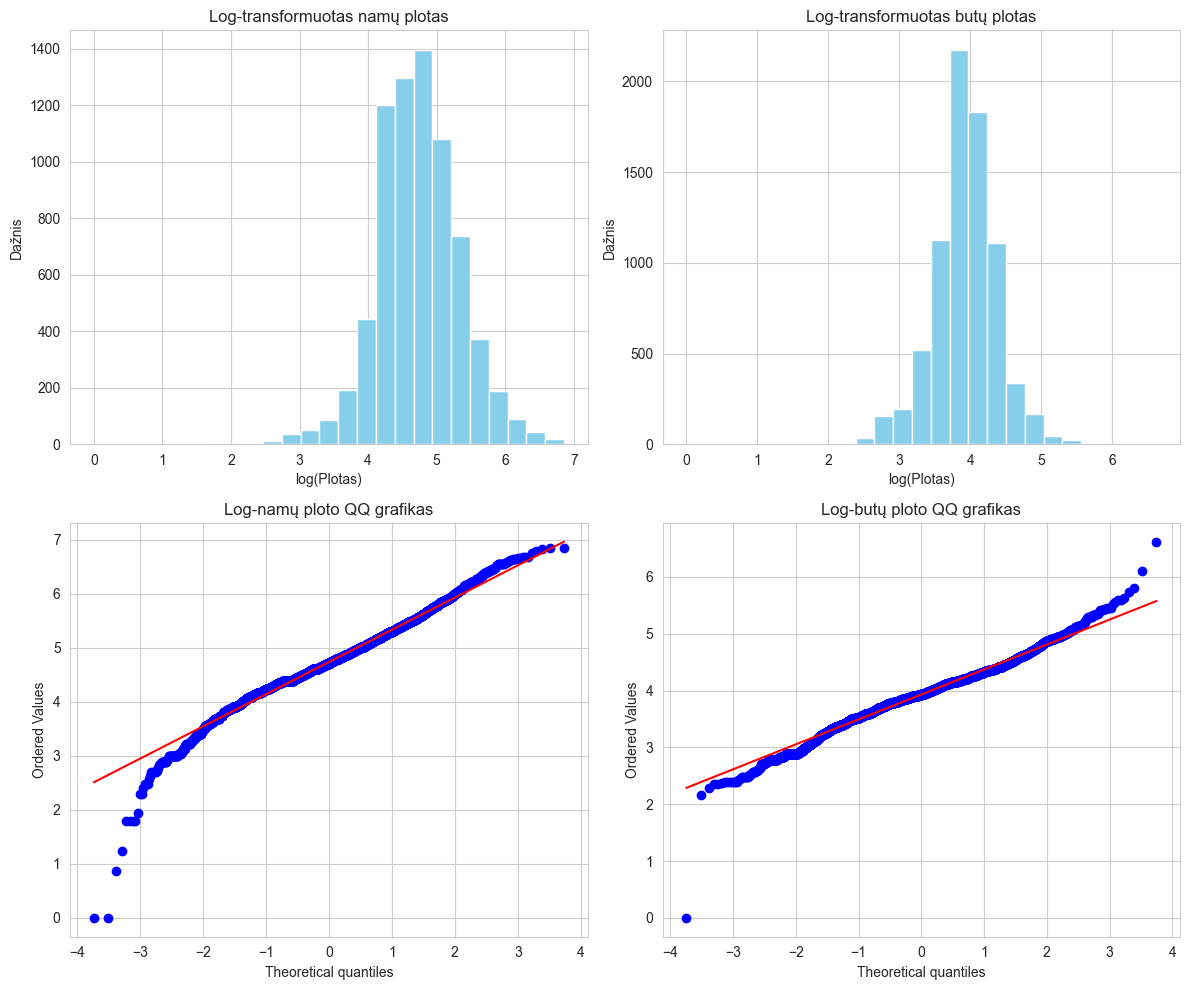

In [138]:
houses_area = pd.to_numeric(csv_data_dict["houses"]["area"].astype(str).str.replace(',', '.'), errors='coerce')
apartments_area = pd.to_numeric(csv_data_dict["apartments"]["area"].astype(str).str.replace(',', '.'), errors='coerce')

houses_area = houses_area[(~houses_area.isna()) & (houses_area > 0) & (houses_area < 1000)]
apartments_area = apartments_area[(~apartments_area.isna()) & (apartments_area > 0) & (apartments_area < 1000)]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].hist(houses_area, bins=25, color='skyblue', edgecolor='white')
axs[0, 0].set_title("Namų ploto pasiskirstymas")
axs[0, 0].set_xlabel("Plotas (kv. m)")
axs[0, 0].set_ylabel("Dažnis")

axs[0, 1].hist(apartments_area, bins=25, color='skyblue', edgecolor='white')
axs[0, 1].set_title("Butų ploto pasiskirstymas")
axs[0, 1].set_xlabel("Plotas (kv. m)")
axs[0, 1].set_ylabel("Dažnis")

stats.probplot(houses_area, plot=axs[1, 0])
axs[1, 0].set_title("Namų ploto QQ grafikas")

stats.probplot(apartments_area, plot=axs[1, 1])
axs[1, 1].set_title("Butų ploto QQ grafikas")

plt.tight_layout()
plt.show()

# log transformacija
log_houses_area = np.log(houses_area)
log_apartments_area = np.log(apartments_area)

fig2, axs2 = plt.subplots(2, 2, figsize=(12, 10))

axs2[0, 0].hist(log_houses_area, bins=25, color='skyblue', edgecolor='white')
axs2[0, 0].set_title("Log-transformuotas namų plotas")
axs2[0, 0].set_xlabel("log(Plotas)")
axs2[0, 0].set_ylabel("Dažnis")

axs2[0, 1].hist(log_apartments_area, bins=25, color='skyblue', edgecolor='white')
axs2[0, 1].set_title("Log-transformuotas butų plotas")
axs2[0, 1].set_xlabel("log(Plotas)")
axs2[0, 1].set_ylabel("Dažnis")

stats.probplot(log_houses_area, plot=axs2[1, 0])
axs2[1, 0].set_title("Log-namų ploto QQ grafikas")

stats.probplot(log_apartments_area, plot=axs2[1, 1])
axs2[1, 1].set_title("Log-butų ploto QQ grafikas")

plt.tight_layout()
plt.show()

In [139]:
log_t_test_results = stats.ttest_ind(log_houses_area, log_apartments_area, 
                                     equal_var=False, 
                                     alternative="greater")

print("Dviejų nepriklausomų imčių testai: nelygios dispersijos")

print(f"duomenys: log_houses_area ir log_apartments_area")
print(f"t = {log_t_test_results.statistic:.4f}, df = {log_t_test_results.df:.2f}, p-value = {log_t_test_results.pvalue:.8f}")

Dviejų nepriklausomų imčių testai: nelygios dispersijos
duomenys: log_houses_area ir log_apartments_area
t = 92.8558, df = 13261.61, p-value = 0.00000000


In [140]:
apartments_private = csv_data_dict["apartments"]["private_seller"]
houses_private = csv_data_dict["houses"]["private_seller"]

apartments_private = apartments_private.dropna()
houses_private = houses_private.dropna()

if not pd.api.types.is_bool_dtype(apartments_private):
    apartments_private = apartments_private == "True"

if not pd.api.types.is_bool_dtype(houses_private):
    houses_private = houses_private == "True"

apartments_private_count = apartments_private.sum()
houses_private_count = houses_private.sum()

apartments_total = len(apartments_private)
houses_total = len(houses_private)

apartments_prop = apartments_private_count / apartments_total
houses_prop = houses_private_count / houses_total

counts = np.array([apartments_private_count, houses_private_count])
totals = np.array([apartments_total, houses_total])
proportions = counts / totals

pooled_prop = counts.sum() / totals.sum()

expected = totals * pooled_prop
corrections = 0.5 * np.ones(len(counts))
corrections = np.minimum(corrections, np.abs(counts - expected))
X_squared = np.sum((np.abs(counts - expected) - corrections)**2 / expected)

p_value = 1 - stats.chi2.cdf(X_squared, 1)

print("2 imčių proporcijų testas")

print(f"duomenys: c({apartments_private_count}, {houses_private_count}) iš c({apartments_total}, {houses_total})")
print(f"X-squared = {X_squared:.4f}, df = 1, p-value = {p_value:.8f}")

2 imčių proporcijų testas
duomenys: c(2284, 2085) iš c(7721, 7284)
X-squared = 1.1470, df = 1, p-value = 0.28418637


In [141]:

premises_area = pd.to_numeric(csv_data_dict["premises"]["area"].astype(str).str.replace(',', '.'), errors='coerce')
premises_rent_area = pd.to_numeric(csv_data_dict["premises_rent"]["area"].astype(str).str.replace(',', '.'), errors='coerce')

premises_area = premises_area[(~premises_area.isna()) & (premises_area > 0) & (premises_area < 10000)]
premises_rent_area = premises_rent_area[(~premises_rent_area.isna()) & (premises_rent_area > 0) & (premises_rent_area < 10000)]

# F-testas
f_stat = np.var(premises_area, ddof=1) / np.var(premises_rent_area, ddof=1)
dfn = len(premises_area) - 1
dfd = len(premises_rent_area) - 1 

p_value = 2 * min(
    stats.f.cdf(f_stat, dfn, dfd),
    stats.f.sf(f_stat, dfn, dfd)
)

alpha = 0.05
ci_lower = f_stat / stats.f.ppf(1-alpha/2, dfn, dfd)
ci_upper = f_stat / stats.f.ppf(alpha/2, dfn, dfd)

print("F-testas")
print(f"duomenys: premises_area ir premises_rent_area")
print(f"F = {f_stat:.4f}, num df = {dfn}, denom df = {dfd}, p-value = {p_value:.8f}")

F-testas
duomenys: premises_area ir premises_rent_area
F = 2.0921, num df = 1475, denom df = 2059, p-value = 0.00000000


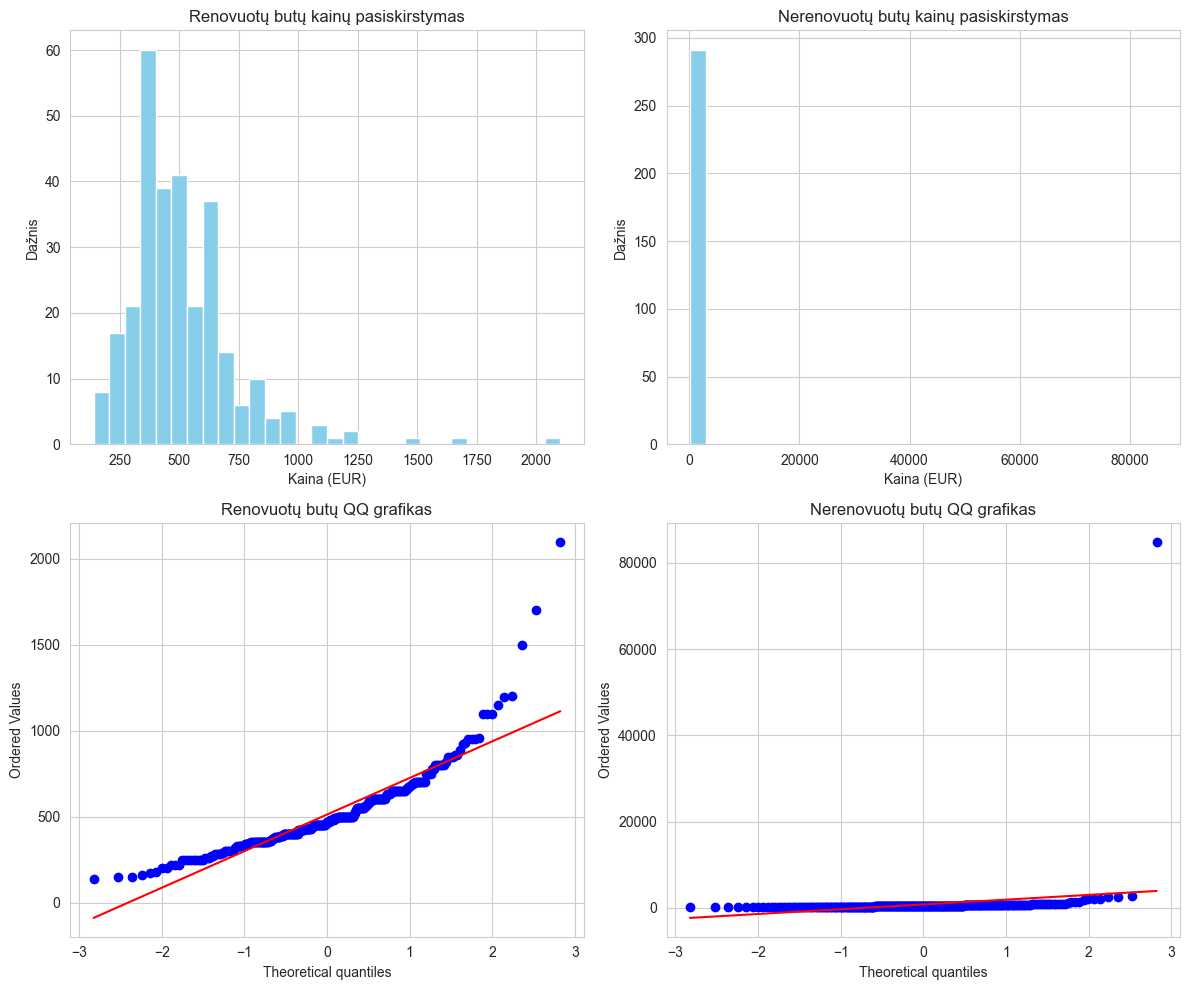

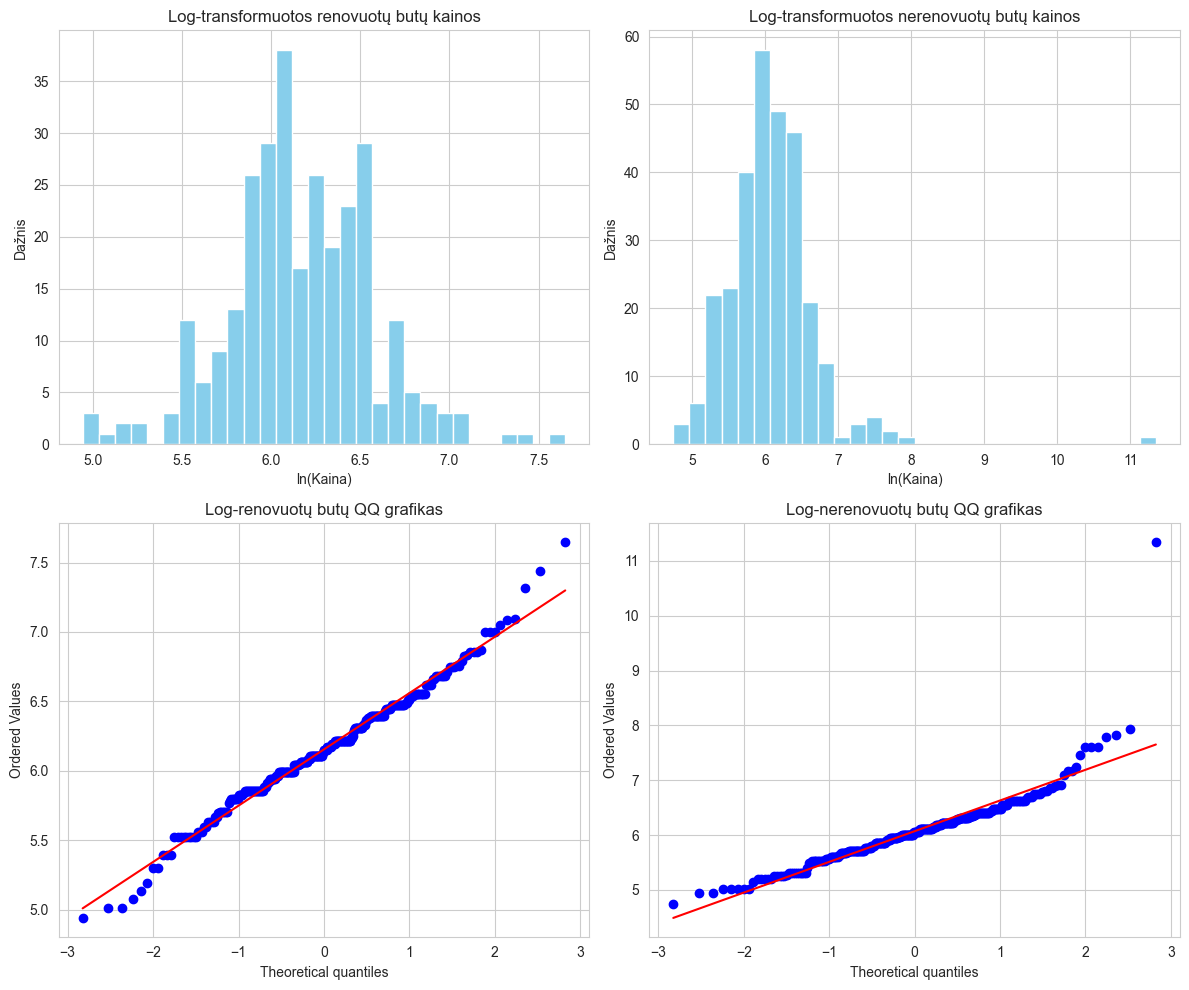

In [142]:
build_year_data = csv_data_dict["apartments_rent"]["build_year"]
price_data = csv_data_dict["apartments_rent"]["price"]

full_data = pd.DataFrame({
    'build_year': build_year_data,
    'price': price_data
})


renovated_data = pd.DataFrame(columns=['build_year', 'price', 'construction_year'])

for i in range(len(full_data)):
    x = str(full_data['build_year'].iloc[i])
    if "construction" in x and "renovation" in x:
        try:
            construction_year = int(x[:4])
            renovation_index = x.find("renovation")
            renovation_year = int(x[renovation_index-5:renovation_index-1])
            
            if not np.isnan(construction_year) and not np.isnan(renovation_year) and construction_year < 2000 and renovation_year > 2010:
                renovated_data = pd.concat([renovated_data, pd.DataFrame({
                    'build_year': [x],
                    'price': [full_data['price'].iloc[i]],
                    'construction_year': [construction_year]
                })], ignore_index=True)
        except:
            continue

if not renovated_data.empty:
    renovated_data = renovated_data.rename(columns={
        'build_year': 'build_year_renovated',
        'price': 'price_renovated'
    })

non_renovated_data = pd.DataFrame(columns=['build_year', 'price', 'construction_year'])

for i in range(len(full_data)):
    x = str(full_data['build_year'].iloc[i])
    if "renovation" not in x:
        if re.match(r'^\d{4}$', x):
            try:
                construction_year = int(x)
                if not np.isnan(construction_year):
                    non_renovated_data = pd.concat([non_renovated_data, pd.DataFrame({
                        'build_year': [x],
                        'price': [full_data['price'].iloc[i]],
                        'construction_year': [construction_year]
                    })], ignore_index=True)
            except:
                continue
        elif "construction" in x:
            try:
                construction_year = int(x[:4])
                if not np.isnan(construction_year):
                    non_renovated_data = pd.concat([non_renovated_data, pd.DataFrame({
                        'build_year': [x],
                        'price': [full_data['price'].iloc[i]],
                        'construction_year': [construction_year]
                    })], ignore_index=True)
            except:
                continue

if not non_renovated_data.empty:
    non_renovated_data = non_renovated_data.rename(columns={
        'build_year': 'build_year_non_renovated',
        'price': 'price_non_renovated'
    })


combined_data = pd.DataFrame({
    'ID_Renovuoto': np.nan,
    'Statybos_Metai_Renovuoto': '',
    'Statybos_Metai_Skaicius_Renovuoto': np.nan,
    'Kaina_Renovuoto': np.nan,
    'ID_Nerenovuoto': np.nan,
    'Statybos_Metai_Skaicius_Nerenovuoto': np.nan,
    'Kaina_Nerenovuoto': np.nan
}, index=range(len(renovated_data)))

for i in range(len(renovated_data)):
    target_year = renovated_data['construction_year'].iloc[i]
    
    matching_indices = non_renovated_data[non_renovated_data['construction_year'] == target_year].index.tolist()
    
    if len(matching_indices) > 0:
        random_idx = random.choice(matching_indices)
    else:
        continue
    
    combined_data.loc[i, 'ID_Renovuoto'] = i
    combined_data.loc[i, 'Statybos_Metai_Renovuoto'] = str(renovated_data['build_year_renovated'].iloc[i])
    combined_data.loc[i, 'Statybos_Metai_Skaicius_Renovuoto'] = renovated_data['construction_year'].iloc[i]
    combined_data.loc[i, 'Kaina_Renovuoto'] = renovated_data['price_renovated'].iloc[i]
    
    combined_data.loc[i, 'ID_Nerenovuoto'] = random_idx
    combined_data.loc[i, 'Statybos_Metai_Skaicius_Nerenovuoto'] = non_renovated_data['construction_year'].iloc[random_idx]
    combined_data.loc[i, 'Kaina_Nerenovuoto'] = non_renovated_data['price_non_renovated'].iloc[random_idx]

combined_data_clean = combined_data.dropna()

combined_data_clean = combined_data_clean[combined_data_clean['Kaina_Renovuoto'] > 0]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].hist(combined_data_clean['Kaina_Renovuoto'], bins=30, color='skyblue', edgecolor='white')
axs[0, 0].set_title("Renovuotų butų kainų pasiskirstymas")
axs[0, 0].set_xlabel("Kaina (EUR)")
axs[0, 0].set_ylabel("Dažnis")

axs[0, 1].hist(combined_data_clean['Kaina_Nerenovuoto'], bins=30, color='skyblue', edgecolor='white')
axs[0, 1].set_title("Nerenovuotų butų kainų pasiskirstymas")
axs[0, 1].set_xlabel("Kaina (EUR)")
axs[0, 1].set_ylabel("Dažnis")

stats.probplot(combined_data_clean['Kaina_Renovuoto'], plot=axs[1, 0])
axs[1, 0].set_title("Renovuotų butų QQ grafikas")

stats.probplot(combined_data_clean['Kaina_Nerenovuoto'], plot=axs[1, 1])
axs[1, 1].set_title("Nerenovuotų butų QQ grafikas")

plt.tight_layout()
plt.show()

# log transformacija
log_kaina_renovuoto = np.log(combined_data_clean['Kaina_Renovuoto'])
log_kaina_nerenovuoto = np.log(combined_data_clean['Kaina_Nerenovuoto'])

fig2, axs2 = plt.subplots(2, 2, figsize=(12, 10))

axs2[0, 0].hist(log_kaina_renovuoto, bins=30, color='skyblue', edgecolor='white')
axs2[0, 0].set_title("Log-transformuotos renovuotų butų kainos")
axs2[0, 0].set_xlabel("ln(Kaina)")
axs2[0, 0].set_ylabel("Dažnis")

axs2[0, 1].hist(log_kaina_nerenovuoto, bins=30, color='skyblue', edgecolor='white')
axs2[0, 1].set_title("Log-transformuotos nerenovuotų butų kainos")
axs2[0, 1].set_xlabel("ln(Kaina)")
axs2[0, 1].set_ylabel("Dažnis")

stats.probplot(log_kaina_renovuoto, plot=axs2[1, 0])
axs2[1, 0].set_title("Log-renovuotų butų QQ grafikas")

stats.probplot(log_kaina_nerenovuoto, plot=axs2[1, 1])
axs2[1, 1].set_title("Log-nerenovuotų butų QQ grafikas")

plt.tight_layout()
plt.show()

In [143]:
t_stat, p_value = stats.ttest_rel(
    log_kaina_renovuoto, 
    log_kaina_nerenovuoto, 
    alternative="greater"
)

df = len(combined_data_clean) - 1

print("Porinis t-testas")
print(f"duomenys: log_kaina_renovuoto ir log_kaina_nerenovuoto")
print(f"t = {t_stat:.4f}, df = {df}, p-value = {p_value:.8f}")

alpha = 0.05
critical_t = stats.t.ppf(1 - alpha, df)
print(f"\nKritinė t-reikšmė (alpha = {alpha}, df = {df}): {critical_t:.4f}")

Porinis t-testas
duomenys: log_kaina_renovuoto ir log_kaina_nerenovuoto
t = 2.2530, df = 291, p-value = 0.01250078

Kritinė t-reikšmė (alpha = 0.05, df = 291): 1.6501
